In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer  # Enables IterativeImputer
from sklearn.impute import IterativeImputer
from fancyimpute import SoftImpute
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.ensemble import StackingRegressor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:

!pip install fancyimpute

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.3 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29881 sha256=ae97fe54c1c4c50e039e892be4eb1ca72ab5f44b7a03ad0041acd1b9af165112
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11330 sha256=7778d041c9a6c81f31562b4269f4ee7a057219d1ef9adce27f20d72aefdda0f1
  Stored in directory: /root/.cache/pip/wheels/46/06/a5/45a724630562413c374e29c08732411d496092408b3a7bf754
Successfully built fancyimpute knnimpute


In [ ]:
data=pd.read_csv('/content/online_retail_customer_churn.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Customer_ID                 1000 non-null   int64  
 1   Age                         1000 non-null   int64  
 2   Gender                      1000 non-null   object 
 3   Annual_Income               1000 non-null   float64
 4   Total_Spend                 1000 non-null   float64
 5   Years_as_Customer           1000 non-null   int64  
 6   Num_of_Purchases            1000 non-null   int64  
 7   Average_Transaction_Amount  1000 non-null   float64
 8   Num_of_Returns              1000 non-null   int64  
 9   Num_of_Support_Contacts     1000 non-null   int64  
 10  Satisfaction_Score          1000 non-null   int64  
 11  Last_Purchase_Days_Ago      1000 non-null   int64  
 12  Email_Opt_In                1000 non-null   bool   
 13  Promotion_Response          1000 n

In [ ]:
data.drop(['Gender', 'Email_Opt_In', 'Promotion_Response', 'Target_Churn', 'Age'], axis=1, inplace=True)

In [ ]:
data2A = data.copy()

In [ ]:
import numpy as np
import random

# Select 2% of the rows
rows_to_modify = random.sample(range(len(data2A)), int(len(data2A) * 0.02))

columns_to_modify = range(1, 10)

# Set the selected values to NaN
for row_index in rows_to_modify:
    for column_index in columns_to_modify:
        data2A.iloc[row_index, column_index] = np.nan

null_values_count = data2A.isnull().sum()
print(null_values_count)

Customer_ID                    0
Annual_Income                 20
Total_Spend                   20
Years_as_Customer             20
Num_of_Purchases              20
Average_Transaction_Amount    20
Num_of_Returns                20
Num_of_Support_Contacts       20
Satisfaction_Score            20
Last_Purchase_Days_Ago        20
dtype: int64


In [ ]:

missing_positions = np.argwhere(pd.isnull(data2A).values)


In [ ]:
import numpy as np
# Initialize KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5)

# Initialize IterativeImputer
iterative_imputer = IterativeImputer(max_iter=10)

# Initialize SimpleImputer with mean strategy
mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Initialize SoftImpute
soft_imputer = SoftImpute()

# Initialize SimpleImputer with median strategy
median_imputer = SimpleImputer(missing_values=np.nan, strategy='median')

In [ ]:
def calculate_rmse(imputed_data, original_data, missing_positions):
    missing_values = [(x, y) for x, y in missing_positions]
    original_values = [original_data.iloc[x, y] for x, y in missing_values]
    imputed_values = [imputed_data[x, y] for x, y in missing_values]
    return np.sqrt(mean_squared_error(original_values, imputed_values))


In [ ]:
# Function to impute missing values using the proposed ensemble method
def ensemble_impute(data_with_missing, missing_positions, original_data):
    ip_temp = data_with_missing.copy()  # Ensure ip_temp is reset for each imputation
    imputed_data = data_with_missing.copy()
    for i in range(len(missing_positions)):
        x, y = missing_positions[i]

        # Impute using KNN
        ip_temp.iloc[x, y] = np.nan
        knn_imputed = knn_imputer.fit_transform(ip_temp)
        knn_value = knn_imputed[x, y]

        # Impute using Iterative Imputer
        ip_temp.iloc[x, y] = np.nan
        iterative_imputed = iterative_imputer.fit_transform(ip_temp)
        iterative_value = iterative_imputed[x, y]

        # Impute using Mean
        ip_temp.iloc[x, y] = np.nan
        mean_imputed = mean_imputer.fit_transform(ip_temp)
        mean_value = mean_imputed[x, y]

        # Impute using SoftImpute
        ip_temp.iloc[x, y] = np.nan
        soft_imputed = SoftImpute().fit_transform(ip_temp)
        soft_value = soft_imputed[x, y]

        # Impute using Median
        ip_temp.iloc[x, y] = np.nan
        median_imputed = median_imputer.fit_transform(ip_temp)
        median_value = median_imputed[x, y]

        # Store the imputed values in a dictionary
        imputed_values = {
            'knn': knn_value,
            'iterative': iterative_value,
            'mean': mean_value,
            'soft': soft_value,
            'median': median_value
        }
        original_value = original_data.iloc[x, y]
        rmses = {method: np.sqrt(mean_squared_error([value], [original_value])) for method, value in imputed_values.items()}

        # Select the method with the smallest RMSE
        best_method = min(rmses, key=rmses.get)

        # Impute the value at (x, y) in the original dataset using the best method
        imputed_data.iloc[x, y] = imputed_values[best_method]

    return imputed_data


In [ ]:
ensemble_imputed = ensemble_impute(data2A, missing_positions, data)

Streaming output truncated to the last 5000 lines.
[SoftImpute] Iter 100: observed MAE=47.556305 rank=3
[SoftImpute] Stopped after iteration 100 for lambda=3659.469383
[SoftImpute] Max Singular Value of X_init = 182973.469136
[SoftImpute] Iter 1: observed MAE=47.507364 rank=3
[SoftImpute] Iter 2: observed MAE=47.535839 rank=3
[SoftImpute] Iter 3: observed MAE=47.544534 rank=3
[SoftImpute] Iter 4: observed MAE=47.547267 rank=3
[SoftImpute] Iter 5: observed MAE=47.548333 rank=3
[SoftImpute] Iter 6: observed MAE=47.548867 rank=3
[SoftImpute] Iter 7: observed MAE=47.549204 rank=3
[SoftImpute] Iter 8: observed MAE=47.549460 rank=3
[SoftImpute] Iter 9: observed MAE=47.549680 rank=3
[SoftImpute] Iter 10: observed MAE=47.549882 rank=3
[SoftImpute] Iter 11: observed MAE=47.550073 rank=3
[SoftImpute] Iter 12: observed MAE=47.550257 rank=3
[SoftImpute] Iter 13: observed MAE=47.550434 rank=3
[SoftImpute] Iter 14: observed MAE=47.550606 rank=3
[SoftImpute] Iter 15: observed MAE=47.550773 rank=3
[So

[SoftImpute] Max Singular Value of X_init = 182973.469136
[SoftImpute] Iter 1: observed MAE=47.507364 rank=3
[SoftImpute] Iter 2: observed MAE=47.535839 rank=3
[SoftImpute] Iter 3: observed MAE=47.544534 rank=3
[SoftImpute] Iter 4: observed MAE=47.547267 rank=3
[SoftImpute] Iter 5: observed MAE=47.548333 rank=3
[SoftImpute] Iter 6: observed MAE=47.548867 rank=3
[SoftImpute] Iter 7: observed MAE=47.549204 rank=3
[SoftImpute] Iter 8: observed MAE=47.549460 rank=3
[SoftImpute] Iter 9: observed MAE=47.549680 rank=3
[SoftImpute] Iter 10: observed MAE=47.549882 rank=3
[SoftImpute] Iter 11: observed MAE=47.550073 rank=3
[SoftImpute] Iter 12: observed MAE=47.550257 rank=3
[SoftImpute] Iter 13: observed MAE=47.550434 rank=3
[SoftImpute] Iter 14: observed MAE=47.550606 rank=3
[SoftImpute] Iter 15: observed MAE=47.550773 rank=3
[SoftImpute] Iter 16: observed MAE=47.550935 rank=3
[SoftImpute] Iter 17: observed MAE=47.551092 rank=3
[SoftImpute] Iter 18: observed MAE=47.551245 rank=3
[SoftImpute] It

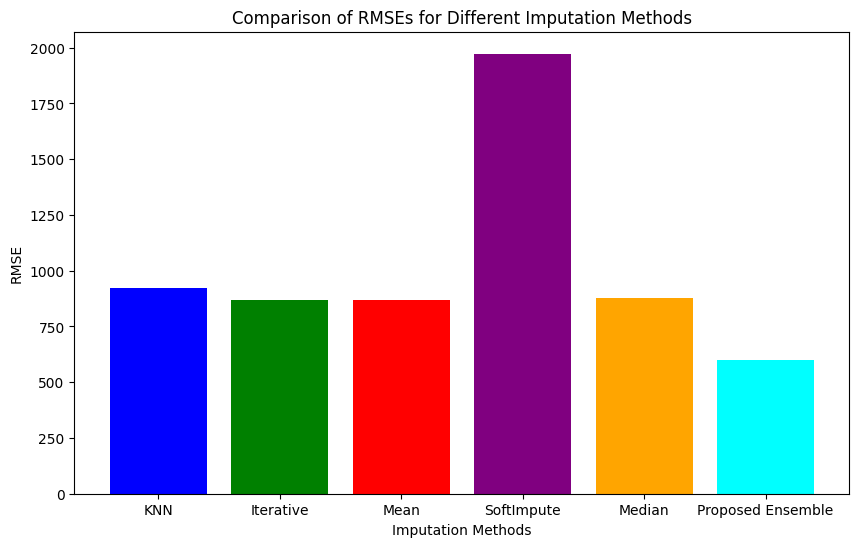

In [ ]:
knn_imputed = knn_imputer.fit_transform(data2A)

# Impute using Iterative Imputer
iterative_imputed = iterative_imputer.fit_transform(data2A)

# Impute using Mean
mean_imputed = mean_imputer.fit_transform(data2A)

# Impute using SoftImpute
soft_imputed = SoftImpute().fit_transform(data2A)

# Impute using Median
median_imputed = median_imputer.fit_transform(data2A)

# Calculate RMSE for each method
knn_rmse = calculate_rmse(knn_imputed, data, missing_positions)
iterative_rmse = calculate_rmse(iterative_imputed, data, missing_positions)
mean_rmse = calculate_rmse(mean_imputed, data, missing_positions)
soft_rmse = calculate_rmse(soft_imputed, data, missing_positions)
median_rmse = calculate_rmse(median_imputed, data, missing_positions)
ensemble_rmse = calculate_rmse(ensemble_imputed.values, data, missing_positions)

# Plot the RMSEs
methods = ['KNN', 'Iterative', 'Mean', 'SoftImpute', 'Median', 'Proposed Ensemble']
rmses = [knn_rmse, iterative_rmse, mean_rmse, soft_rmse, median_rmse, ensemble_rmse]

plt.figure(figsize=(10, 6))
plt.bar(methods, rmses, color=['blue', 'green', 'red', 'purple', 'orange', 'cyan'])
plt.xlabel('Imputation Methods')
plt.ylabel('RMSE')
plt.title('Comparison of RMSEs for Different Imputation Methods')
plt.show()